<a href="https://colab.research.google.com/github/ajibigad/ML-Playground/blob/main/celeb_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## The plan
- Download celeb dataset
- Understand folder structure
- Write label extractor
- Fetch all images and view one batch
- Create datablock
  - Image datablock, Category datapoint
- Create dataloaders
- Create a learner with resnet 50
- Fine tune

In [1]:
import zipfile
from pathlib import Path

# Define the paths
# Dataset can be found here https://www.kaggle.com/datasets/vishesh1412/celebrity-face-image-dataset/data
zip_path = '/content/drive/My Drive/Colab Notebooks/data/celebs.zip'
extract_path = Path('/content/data')

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Define the path to the extracted dataset
path = Path('/content/data/Celebrity Faces Dataset')


In [2]:
import os
import shutil
from pathlib import Path

# Scarlett Johansson has 100 images more than other categories. Remove 100 images to make it equal amongst other categories
source_dir = path/'Scarlett Johansson'
dest_dir = Path('/content/data/Scarlett')

# List all files in the source directory
files = list(source_dir.glob('*'))
print(f"old file count {len(files)}")

for file in files[:100]:
    shutil.move(str(file), dest_dir)

print(f"Moved {min(100, len(files))} files from {source_dir} to {dest_dir}.")

files = list(source_dir.glob('*'))
print(f"new file count {len(files)}")


old file count 200
Moved 100 files from /content/data/Celebrity Faces Dataset/Scarlett Johansson to /content/data/Scarlett.
new file count 100


In [3]:
from fastai.vision.all import *

# Load the dataset from the folder structure
fnames = get_image_files(path)
len(fnames)


1700

In [ ]:
def label_func(x): return x.parent.name
def get_dls(size):
  return ImageDataLoaders.from_path_func(path, fnames, label_func, item_tfms=Resize(460), batch_tfms=aug_transforms(size=size, min_scale=0.75))

dls = get_dls(128)
# Show a batch of images to verify. To view the data augmentation done to one image, pass `unique=True` args to show_batch
dls.show_batch(unique=True)

In [5]:
x,y = dls.one_batch()

# independent variables are normalized. mean = 0, standard deviation = 1
x.mean(dim=[0,2,3]),x.std(dim=[0,2,3])

(TensorImage([0.4462, 0.3941, 0.3747], device='cuda:0'),
 TensorImage([0.3291, 0.2966, 0.2879], device='cuda:0'))

In [17]:
learn = vision_learner(get_dls(224), resnet50, metrics=accuracy)
# learn.lr_find()

learn.fine_tune(6, 3e-3)

# Delete old DataLoader before loading a new one
del learn.dls

# Manually trigger garbage collection
import gc
gc.collect()

learn.dls = get_dls(224*2)
learn.fine_tune(2, 1e-3)

gc.collect()

epoch,train_loss,valid_loss,accuracy,time
0,3.220295,1.692397,0.452941,00:05


epoch,train_loss,valid_loss,accuracy,time
0,1.379055,1.250630,0.570588,00:05
1,1.048537,0.971906,0.673529,00:05
2,0.797853,0.898811,0.711765,00:05
3,0.603259,0.769139,0.761765,00:05
4,0.451048,0.772160,0.773529,00:05
5,0.361070,0.760104,0.776471,00:05


epoch,train_loss,valid_loss,accuracy,time
0,1.012687,0.481407,0.835294,00:09


epoch,train_loss,valid_loss,accuracy,time
0,0.659725,0.326453,0.885294,00:09
1,0.543128,0.309542,0.900000,00:10


340

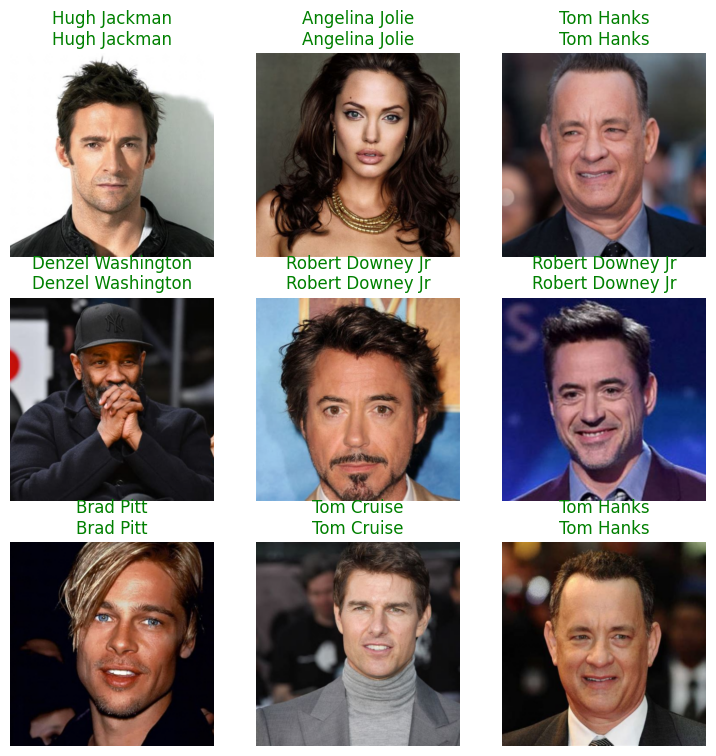

In [18]:
learn.show_results()

In [ ]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,10))

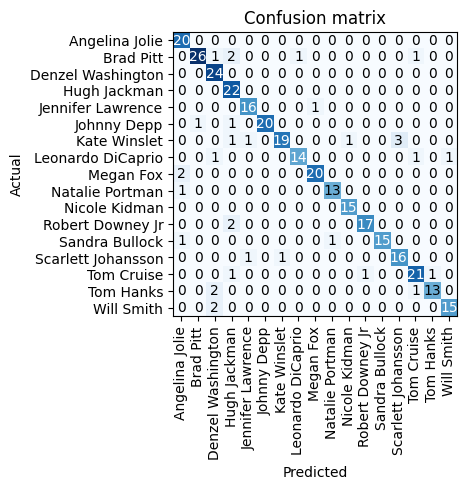

In [23]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
# interp.plot_confusion_matrix(figsize=(18,18), dpi=60)

In [ ]:
from fastai.vision.widgets import *

cleaner = ImageClassifierCleaner(learn, height=224, width=224)
cleaner

('Will Smith',
 tensor(16),
 tensor([2.8057e-07, 2.2607e-05, 1.0041e-05, 9.9720e-06, 2.1858e-07, 6.2177e-09,
         1.2323e-07, 2.0833e-07, 1.0573e-07, 1.0026e-04, 5.9397e-07, 3.0749e-04,
         6.1212e-09, 2.0597e-06, 9.7303e-07, 5.6768e-06, 9.9954e-01]))

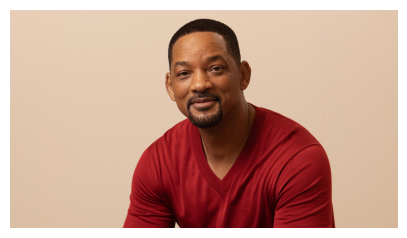

In [28]:
import requests
from io import BytesIO

# URL of the image you want to predict
image_url = 'https://cdn.britannica.com/45/240445-050-B013DA13/British-actress-Kate-Winslet-2022.jpg'
image_url = 'https://t1.pixers.pics/img-1fb6f67c/canvas-prints-brad-pitt.jpg?H4sIAAAAAAAAA3VOSW7DMAz8jg04JiPakuUf5JYfGFpTtV4ESWmDvr4yih4LHsghOQs896y8A-P24hJswdrVgQ9rRXlOLodv12BH09DOdbs2iNjOx6dLJh2xXi5X4h3n2I2svnypyttU-mjeSol5BsjUx_CqYrWZDGbLwPAqAAnGyVqnRpJW4bTE9Sj7cSF8Mezj_ujwrPYvg0DsxOldUtiaGuaoPqV5j48W_vH6naGy4H4DQUB4guV-E0S4-GEiJi2XEo1hWls_yMkPzGtFgiFbRi2UVpZbobhb-h8PpMQ3KwEAAA=='
# image_url = 'https://images.mubicdn.net/images/cast_member/16575/cache-1434-1559154026/image-w856.jpg'
image_url = 'https://www.hollywoodreporter.com/wp-content/uploads/2024/02/Will-Smith-Red-Sea-Film-Fest-GettyImages-1834600619-H-2024.jpg'

# Download the image from the URL
response = requests.get(image_url)

img_fastai = PILImage.create(BytesIO(response.content))

# Optionally, display the image
img_fastai.show()
learn.predict(img_fastai)